## Imports

In [1]:
import os
import random
import sys
import time
from collections import namedtuple
from copy import deepcopy
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from skimage import io, transform
from sklearn import metrics
from tqdm import tqdm_notebook as tqdm

import cv2
import torch
import torch.hub
import torch.nn.functional as F
import torchvision
from albumentations import (
    CenterCrop,
    Compose,
    HorizontalFlip,
    Normalize,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    VerticalFlip,
)
from albumentations.pytorch import ToTensor

from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.utils import make_grid

In [2]:
from utils.gradcam import GradCAM, GradCAMpp
from utils.ranger import Ranger
from utils.nn_utils import AlbuSingleAttrDataset, get_image
from utils.utils import error_plot, acc_plot, performance_metrics

## Load jupyter extension

In [3]:
#%load_ext pycodestyle_magic
#%flake8_on --max_line_length 99

In [4]:
batch_size = bs = 32
im_size = 500
# im_crop = 299  # Image net standards
im_crop = 224
path_to_data = "data/custom_attr_dataset/"
# path_to_nn_weights = "Pretrained_weights/"

## Load labels 

In [5]:
def parse_column(df, column_to_parse, num_splits, pat=" "):
    """
    describe:
        create new columns based on split old one.

    http://pandas.pydata.org/pandas-docs/stable/text.html
    
    Returns:
        modified DataFrame
    """
    df = df.copy()
    df_temp = (
        df[column_to_parse]
        .str.split(pat=pat, expand=True, n=num_splits)
        .rename(lambda x: "%s_part_{}".format(x + 1) % (column_to_parse), axis=1)
    )
    df = pd.concat([df, df_temp], axis=1)
    return df

## Check and remove bad images

## Create labels dataframe 

In [6]:
def create_labels_df_from_folders(path_to_data):
    """Scans the folder structure and creates a dataframe with class paths and labels.
    The first part of the folder name of the dress - the type of neck,
    the second-the color of clothing
    
    Folder structure:
    - path_to_data_folder
        - roundneck_black
            - img1.jpg
            ...
            - img100.jpg
        - vneck_white
            - img245.jpg
            - ...
        - roundneck_white
            - img245.jpg
            - ...
        - ...
    Args:
        path_to_data - path to folder with subfolders

    Returns:
        pandas Dataframe with path, neck, color columns
    """
    subfolders = [f.path for f in os.scandir(path_to_data) if f.is_dir()]
    d = {}

    for folder in subfolders:
        for file in os.listdir(folder):
            d[os.path.join(folder, file)] = folder.split("/")[-1]
    labels_df = pd.DataFrame.from_dict(data=d, orient="index", columns=["class"])
    labels_df = labels_df.reset_index()
    labels_df = parse_column(labels_df, "class", 1, pat="_").rename(
        columns={"class_part_1": "neck", "class_part_2": "color", "index": "path"}
    )
    labels_df = labels_df.drop(columns=["class"])
    return labels_df

In [7]:
labels_df = create_labels_df_from_folders(path_to_data)
labels_df.head()

path       neck  color
0  ../Fashion_datasets/my_dataset/roundneck_black...  roundneck  black
1  ../Fashion_datasets/my_dataset/roundneck_black...  roundneck  black
2  ../Fashion_datasets/my_dataset/roundneck_black...  roundneck  black
3  ../Fashion_datasets/my_dataset/roundneck_black...  roundneck  black
4  ../Fashion_datasets/my_dataset/roundneck_black...  roundneck  black

# Select target columns

In [8]:
X_feat_is_cat = np.where(
    (labels_df.dtypes == "category") | (labels_df.dtypes == "object")
)[0]
cols_need_mapped = [x for x in labels_df.columns[X_feat_is_cat] if x not in ["path"]]
print(cols_need_mapped)
target_attr = cols_need_mapped

['neck', 'color']


### Create mapper dict {column_name: {old_label: int_label}}

In [9]:
mapper = {
    col: {
        cat: n for n, cat in enumerate(labels_df[col].astype("category").cat.categories)
    }
    for col in labels_df[cols_need_mapped]
}

for c in cols_need_mapped:
    labels_df[c] = labels_df[c].map(mapper[c])
inv_mapper = {
    k_name: {v: k for k, v in v_dict.items()} for k_name, v_dict in mapper.items()
}
target_inv_mappers = [inv_mapper[x] for x in target_attr]

In [10]:
labels_df = labels_df.dropna(thresh=len(mapper))
assert (
    labels_df[target_attr].isna().sum().all() == 0
), f"fill or drop rows with nan in {target_attr} column"

## split indexes to train/valid/test
train size ~ 50% , valid size ~50%, test size = 1 img

In [11]:
np.random.seed(5)

In [12]:
idx_arr = deepcopy(labels_df.index.values)
print(len(idx_arr))
train_size = int(0.5 * len(idx_arr))
val_size = int(0.5 * len(idx_arr))
test_size = 1  # len(idx_arr) - train_size - val_size
np.random.shuffle(idx_arr)

1784


In [13]:
train_idx = idx_arr[:train_size]
val_idx = idx_arr[train_size : val_size + train_size]
test_idx = idx_arr[-test_size:]
train_size, val_size, test_size

(892, 892, 1)

## Calculate mean and std of all dataset

In [14]:
def normalization_parameter(dataloader):
    mean = 0.0
    std = 0.0
    nb_samples = len(dataloader.dataset)
    for data, _ in tqdm(dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
    mean /= nb_samples
    std /= nb_samples
    return mean.numpy(), std.numpy()

In [15]:
%%time

train_transforms = Compose([Resize(im_size, im_size), ToTensor()])


all_data = AlbuSingleAttrDataset(
    label_df=labels_df,
    target_attr=target_attr,
    indexes=idx_arr,
    transform=train_transforms,
)

all_loader = DataLoader(all_data, batch_size=bs, shuffle=True)
mean, std = normalization_parameter(all_loader)
print(mean, std)


[0.73891556 0.73685    0.7467318 ] [0.24592695 0.24136424 0.23513635]
Wall time: 41.5 s


## Check normalization

In [16]:
train_transforms = Compose([Resize(im_size, im_size), Normalize(mean, std), ToTensor()])

all_data = AlbuSingleAttrDataset(
    label_df=labels_df,
    target_attr=target_attr,
    indexes=idx_arr,
    transform=train_transforms,
)
all_loader = DataLoader(all_data, batch_size=bs, shuffle=True)
new_mean, new_std = normalization_parameter(all_loader)

In [17]:
is_normalize = (
    np.isclose(new_mean, 0.0, atol=0.01).all()
    & np.isclose(new_std, 1.0, atol=0.01).all()
)
assert is_normalize, "mean must be ~ 0, std ~ 1"

## define image transforms with albumentation library

In [18]:
image_transforms = {
    "train": Compose(
        [
            # Resize(im_crop, im_crop),
            RandomResizedCrop(height=im_crop, width=im_crop, scale=(0.95, 1.0)),
            Rotate(limit=90),
            HorizontalFlip(),
            VerticalFlip(),
            Normalize(mean, std),
            ToTensor(),
        ]
    ),
    "valid": Compose([Resize(im_crop, im_crop), Normalize(mean, std), ToTensor()]),
}

In [19]:
# inverse normalization for image plot

inv_normalize = Normalize(
    mean=-1 * np.divide(mean, std),
    std=1 / std,
    max_pixel_value=1,  # in pytorch tensor values between 0-1
)

## create pytorch datasets and dataloaders

In [20]:
data = {
    "train": AlbuSingleAttrDataset(
        label_df=labels_df,
        target_attr=target_attr,
        indexes=train_idx,
        transform=image_transforms["train"],
    ),
    "valid": AlbuSingleAttrDataset(
        label_df=labels_df,
        target_attr=target_attr,
        indexes=val_idx,
        transform=image_transforms["valid"],
    ),
    "test": AlbuSingleAttrDataset(
        label_df=labels_df,
        target_attr=target_attr,
        indexes=test_idx,
        transform=image_transforms["valid"],
    ),
}
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data["train"])
valid_data_size = len(data["valid"])
test_data_size = len(data["test"])

# Create iterators for the Data loaded using DataLoader module
train_data = DataLoader(data["train"], batch_size=bs, shuffle=True)
valid_data = DataLoader(data["valid"], batch_size=bs, shuffle=True)
test_data = DataLoader(data["test"], batch_size=bs, shuffle=True)

## Plot subsamples

In [21]:
def decode_label(label_iter, inv_mappers):
    assert len(label_iter) == len(inv_mappers), "len must be same"
    dec_list_label = [m[l] for l, m in zip(label_iter, inv_mappers)]
    return " | ".join(dec_list_label)

In [22]:
# plotting rondom images from dataset
def class_plot(data, inv_mapper=None, inv_normalize=None, n_figures=12):
    """
    Visualize some pairs from siamese dataset

    Args:
        data: pytorch dataset, dataset output format:img_0,img_1,label,name0,name1
            img_0,img_1 - numpy arrays
            label - number, 1 - images has same class, 0 - differ
            name0, name1 - str
        inv_mapper : list of inv_mapper dicts 
        inv_normalize: albumentation transforms
        n_figures : number of plots

    Returns:
        plots with titles
    """
    n_row = int(n_figures / 4)
    fig, axes = plt.subplots(figsize=(20, 20), nrows=n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0, len(data) - 1)
        (image, labels) = data[a]
        # image is torch tensor
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.numpy().transpose(1, 2, 0)
        if inv_normalize is not None:
            image = inv_normalize(image=image)["image"]

        string_label = decode_label(labels, inv_mapper)
        image = image.clip(0, 1)
        ax.imshow(image)
        ax.set_title(string_label)
        ax.axis("off")
    plt.show()

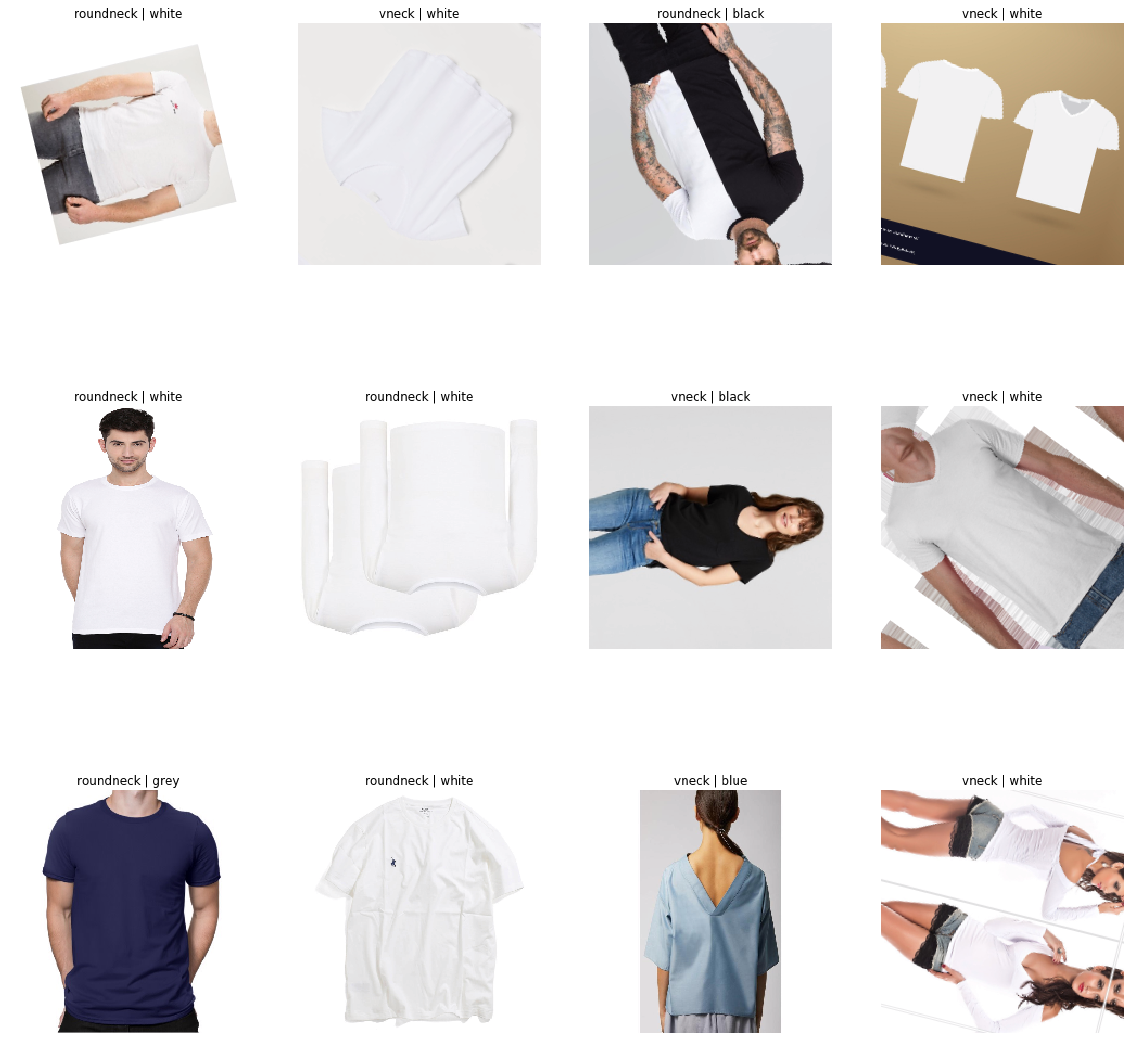

In [23]:
class_plot(data["train"], target_inv_mappers, inv_normalize)

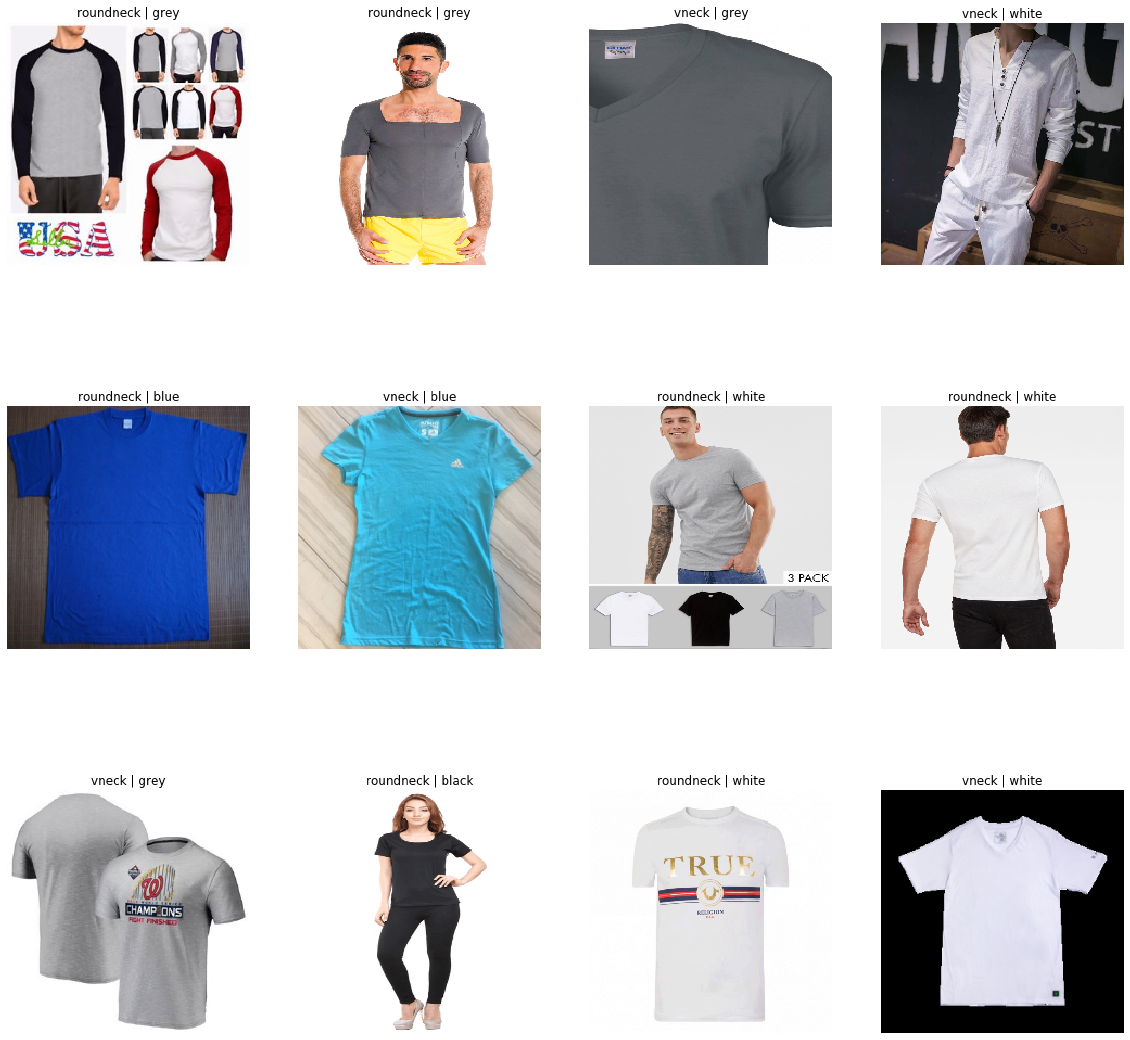

In [24]:
class_plot(data["valid"], target_inv_mappers, inv_normalize=inv_normalize)

In [25]:
# functions to show an batch image

# get some random training images
dataiter = iter(train_data)
images, labels = dataiter.next()

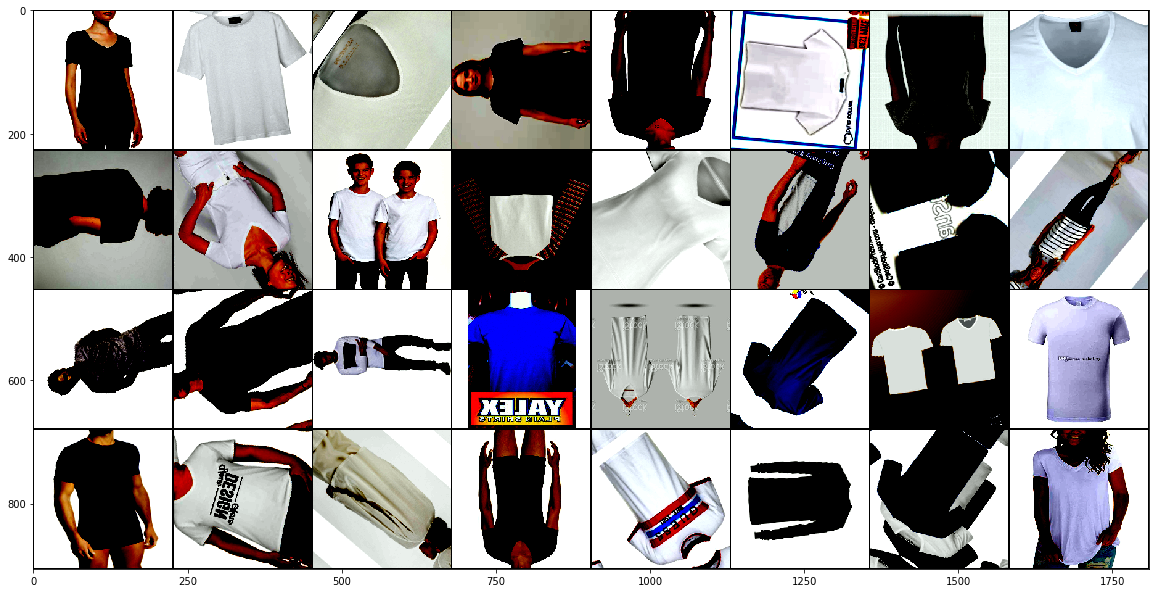

In [26]:
# show images
grid_tensor = torchvision.utils.make_grid(images)
grid_image = grid_tensor.numpy().transpose(1, 2, 0).clip(0, 1)
plt.figure(figsize=(20, 20))
plt.imshow(grid_image)
plt.show()

# define network

 ## Load pretrained resnet network and freeze some layers

In [27]:
target_attr

['neck', 'color']

In [28]:
resnet = torchvision.models.resnet50(pretrained=True)
# state = torch.load(path_to_nn_weights + "resnet50-19c8e357.pth")
# resnet.load_state_dict(state)

# for name, child in resnet.named_children():
#     print(name)

for name, child in resnet.named_children():
    if name in ["fc", "avgpool", "layer4"]:
        print(name + " is unfrozen")
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + " is frozen")
        for param in child.parameters():
            param.requires_grad = False

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is unfrozen
avgpool is unfrozen
fc is unfrozen


# Define custom multyhead neural net

In [29]:
def head_block(in_f, out_f):
    return nn.Sequential(
        nn.Linear(in_f, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 10),
        nn.ReLU(inplace=True),
        nn.Linear(10, out_f),
    )

In [30]:
class Multyhead_net(nn.Module):
    """ Multyhead_net is neural net with N heads.
        output - list of head ouputs.
        head output - raw logits,
        the number of neurons is determined by the number of unique attribute values
        
        Attributes:
            pretrained_resnet - pretrained network with forward method
            num_classes: a list with the number of unique labels in each attribute
            len(num_classes) => number of heads
    """

    def __init__(self, pretrained_resnet, num_classes):
        super().__init__()
        self.backbone = pretrained_resnet
        backbone_fc_outputs = pretrained_resnet.fc.out_features
        self.head_blocks = nn.ModuleList(
            [head_block(backbone_fc_outputs, out_f) for out_f in num_classes]
        )

    def forward(self, inputs):
        output_list = []
        output = self.backbone(inputs)
        output = output.view(output.size()[0], -1)
        output = F.relu(output)
        for head in self.head_blocks:
            head_out = head(output)
            output_list.append(head_out)
        return output_list

In [31]:
torch.cuda.empty_cache()

In [32]:
# print(labels_df[target_attr].unique())
num_classes = [len(labels_df[target_a].unique()) for target_a in target_attr]
_ = [
    print(attr, "has", nclasses, "unique classes")
    for attr, nclasses in zip(target_attr, num_classes)
]
print("union number of classes =", np.sum(num_classes))

neck has 2 unique classes
color has 4 unique classes
union number of classes = 6


In [33]:
model = Multyhead_net(deepcopy(resnet), num_classes)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0004)
scheduler = CosineAnnealingWarmRestarts(optimizer, 5)
loss_func = nn.CrossEntropyLoss(reduction="mean")

cuda


## Train

In [35]:
epochs = 20

In [36]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [37]:
def loss_acc_per_head(outputs, labels, loss_func):
    """Accepts outputs of the neural network and the true labels,
    for a given function, calculates the loss function independently for each head (attribute)
    also calculates the batch accuracy for each attribute

    Args:
        outputs: list of torch tensors, each tensor - raw logits from nn head.
        labels: torch.Tensor with shape [batch_size, num_attributes]
        loss_func : pytorch loss function 

    Returns:
        class_losses_list: list of losses for each head (attribute)
        batch_acc_list: list of sliding accuracies per head(attr)
    """
    class_losses_list = []
    batch_acc_list = []
    for class_idx, class_logits in enumerate(outputs):
        class_labels = labels[:, class_idx]
        class_loss = loss_func(class_logits, class_labels)
        class_losses_list.append(class_loss)
        ret, predictions = torch.max(class_logits.data, 1)
        correct_counts = predictions.eq(class_labels.data.view_as(predictions))
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        batch_acc_list.append(acc.item() * labels.size(0))
    return class_losses_list, batch_acc_list

In [38]:
history = []

In [39]:
for epoch in tqdm(range(epochs)):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch + 1, epochs))

    # Set to training mode
    model.train()

    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0

    valid_loss = 0.0
    valid_acc = 0.0

    epoch_acc_list = []
    valid_epoch_acc_list = []
    for i, (inputs, labels) in tqdm(enumerate(train_data)):
        inputs = inputs.to(device)
        labels = labels.type(torch.LongTensor).to(device)

        # Clean existing gradients
        optimizer.zero_grad()

        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)

        # Compute loss
        class_losses_list, batch_acc_list = loss_acc_per_head(
            outputs, labels, loss_func
        )
        loss = torch.mean(torch.stack(class_losses_list))
        epoch_acc_list.append(batch_acc_list)

        # Backpropagate the gradients
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)
    scheduler.step()
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(valid_data):
            inputs = inputs.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            class_losses_list, val_batch_acc_list = loss_acc_per_head(
                outputs, labels, loss_func
            )
            loss = torch.mean(torch.stack(class_losses_list))

            valid_loss += loss.item() * inputs.size(0)
            # Compute the total loss for the batch and add it to valid_loss
            valid_epoch_acc_list.append(val_batch_acc_list)

        # Find average training loss and training accuracy
        avg_train_loss = train_loss / train_data_size
        avg_train_acc_per_class = np.array(epoch_acc_list).sum(axis=0) / float(
            train_data_size
        )
        avg_train_acc = np.mean(avg_train_acc_per_class)

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc_per_class = np.array(valid_epoch_acc_list).sum(axis=0) / float(
            valid_data_size
        )
        avg_valid_acc = np.mean(avg_valid_acc_per_class)

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()

        print(
            "avg train acc per class",
            avg_train_acc_per_class,
            "average:",
            avg_train_acc,
        )

        print(
            "avg valid acc per class",
            avg_valid_acc_per_class,
            "average:",
            avg_valid_acc,
        )

        print("Epoch : {:03d},\nTraining  : Loss: {:.4f}".format(epoch, avg_train_loss))
        print(
            "Validation: Loss: {:.4f},\n Time: {:.4f}s".format(
                avg_valid_loss, epoch_end - epoch_start
            )
        )

Epoch: 1/20



avg train acc per class [0.53251121 0.73206278] average: 0.6322869951147669
avg valid acc per class [0.54035874 0.81278027] average: 0.6765695067932788
Epoch : 000,
Training  : Loss: 0.7321
Validation: Loss: 0.7505,
 Time: 36.3193s
Epoch: 2/20



avg train acc per class [0.58632287 0.8587444 ] average: 0.7225336325542808
avg valid acc per class [0.56950673 0.86995516] average: 0.719730942104964
Epoch : 001,
Training  : Loss: 0.5465
Validation: Loss: 0.5932,
 Time: 35.1946s
Epoch: 3/20



avg train acc per class [0.62107623 0.90134529] average: 0.761210763000052
avg valid acc per class [0.62780269 0.85201794] average: 0.7399103145695587
Epoch : 002,
Training  : Loss: 0.4806
Validation: Loss: 0.6045,
 Time: 35.0540s
Epoch: 4/20



avg train acc per class [0.66928251 0.91704036] average: 0.7931614351112212
avg valid acc per class [0.6793722  0.86995516] average: 0.7746636765954741
Epoch : 003,
Training  : Loss: 0.4153
Validation: Loss: 0.5130,
 Time: 35.1008s
Epoch: 5/20



avg train acc per class [0.75336323 0.92040359] average: 0.8368834082053915
avg valid acc per class [0.72197309 0.88004484] average: 0.8010089684762227
Epoch : 004,
Training  : Loss: 0.3870
Validation: Loss: 0.4890,
 Time: 35.0852s
Epoch: 6/20



avg train acc per class [0.71973094 0.89013453] average: 0.8049327358269371
avg valid acc per class [0.68834081 0.78139014] average: 0.7348654716538742
Epoch : 005,
Training  : Loss: 0.4357
Validation: Loss: 0.6986,
 Time: 35.0852s
Epoch: 7/20



avg train acc per class [0.75112108 0.87892377] average: 0.8150224216583064
avg valid acc per class [0.7029148  0.84529148] average: 0.774103139013453
Epoch : 006,
Training  : Loss: 0.4220
Validation: Loss: 0.6142,
 Time: 35.0227s
Epoch: 8/20



avg train acc per class [0.81165919 0.90246637] average: 0.8570627805363438
avg valid acc per class [0.78026906 0.86434978] average: 0.8223094171740015
Epoch : 007,
Training  : Loss: 0.3607
Validation: Loss: 0.4877,
 Time: 34.9759s
Epoch: 9/20



avg train acc per class [0.83744395 0.92600897] average: 0.8817264572654604
avg valid acc per class [0.71300448 0.86883408] average: 0.7909192821102826
Epoch : 008,
Training  : Loss: 0.2962
Validation: Loss: 0.5221,
 Time: 35.1321s
Epoch: 10/20



avg train acc per class [0.87892377 0.94730942] average: 0.9131165913936803
avg valid acc per class [0.80717489 0.87892377] average: 0.8430493270869748
Epoch : 009,
Training  : Loss: 0.2414
Validation: Loss: 0.4418,
 Time: 35.2571s
Epoch: 11/20



avg train acc per class [0.81390135 0.9103139 ] average: 0.8621076229174576
avg valid acc per class [0.70515695 0.80941704] average: 0.7572869957829804
Epoch : 010,
Training  : Loss: 0.3429
Validation: Loss: 0.7350,
 Time: 35.0852s
Epoch: 12/20



avg train acc per class [0.79820628 0.89798206] average: 0.8480941709381582
avg valid acc per class [0.76457399 0.83856502] average: 0.8015695067264574
Epoch : 011,
Training  : Loss: 0.3623
Validation: Loss: 0.5764,
 Time: 35.0852s
Epoch: 13/20



avg train acc per class [0.85313901 0.93273543] average: 0.8929372197309418
avg valid acc per class [0.77017937 0.85762332] average: 0.8139013454251225
Epoch : 012,
Training  : Loss: 0.2814
Validation: Loss: 0.5146,
 Time: 35.1946s
Epoch: 14/20



avg train acc per class [0.88565022 0.95179372] average: 0.9187219734950984
avg valid acc per class [0.81726457 0.85762332] average: 0.8374439461883407
Epoch : 013,
Training  : Loss: 0.2148
Validation: Loss: 0.4937,
 Time: 35.4133s
Epoch: 15/20



avg train acc per class [0.90246637 0.9573991 ] average: 0.9299327352923663
avg valid acc per class [0.82623318 0.86547085] average: 0.8458520172690063
Epoch : 014,
Training  : Loss: 0.1846
Validation: Loss: 0.5017,
 Time: 35.1790s
Epoch: 16/20



avg train acc per class [0.89573991 0.94955157] average: 0.922645740311242
avg valid acc per class [0.74439462 0.7970852 ] average: 0.7707399107148294
Epoch : 015,
Training  : Loss: 0.2211
Validation: Loss: 0.6801,
 Time: 35.1790s
Epoch: 17/20



avg train acc per class [0.88004484 0.92264574] average: 0.9013452912125353
avg valid acc per class [0.80269058 0.77017937] average: 0.7864349773111899
Epoch : 016,
Training  : Loss: 0.2831
Validation: Loss: 0.6513,
 Time: 35.1477s
Epoch: 18/20



avg train acc per class [0.89686099 0.93609866] average: 0.9164798210287308
avg valid acc per class [0.79372197 0.86547085] average: 0.8295964130906246
Epoch : 017,
Training  : Loss: 0.2331
Validation: Loss: 0.5293,
 Time: 35.1008s
Epoch: 19/20



avg train acc per class [0.91816144 0.94282511] average: 0.9304932740771716
avg valid acc per class [0.80829596 0.87443946] average: 0.8413677130044843
Epoch : 018,
Training  : Loss: 0.1828
Validation: Loss: 0.5116,
 Time: 34.9915s
Epoch: 20/20



avg train acc per class [0.94282511 0.95403587] average: 0.9484304928726145
avg valid acc per class [0.81502242 0.87331839] average: 0.8441704043893001
Epoch : 019,
Training  : Loss: 0.1320
Validation: Loss: 0.5021,
 Time: 35.0696s



## Plot loss and accuracy

train


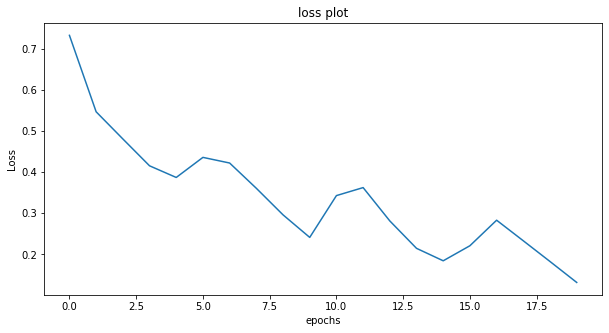

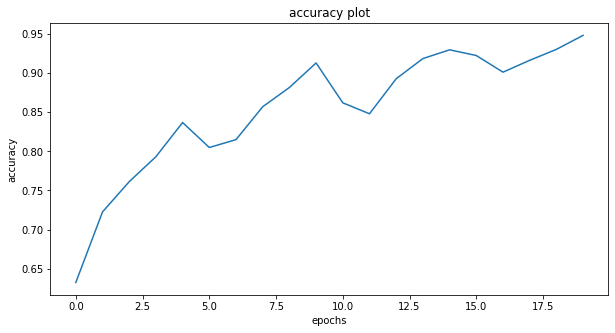

In [40]:
print("train")
error_plot([x[0] for x in history])
acc_plot([x[2] for x in history])

validation


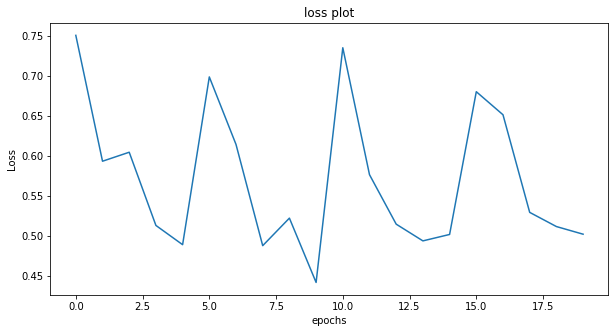

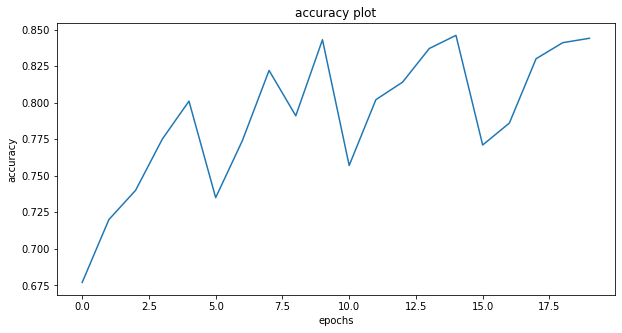

In [41]:
print("validation")
error_plot([x[1] for x in history])
acc_plot([round(x[3], 3) for x in history])

## Test stage

In [42]:
def test(dataloader, device):
    """iterate from dataloader and save predictions

    Args:
        dataloader:Pytorch dataloader
        device: cuda or cpu

    Returns:
        true labels, predicted labels, bad classified images,
        true labels for this images, wrong predicted labels/
    """
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    images = []
    sm = nn.Softmax(dim=1)
    for batch_idx, (data, target) in enumerate(dataloader):

        data = data.to(device)
        target = target.to(device)
        model.eval()
        model.to(device)
        outputs = model(data)
        preds = []
        output_per_class = outputs  # torch.split(outputs, num_classes, dim=1)
        for class_logits in output_per_class:
            output = sm(class_logits)
            _, predictions = torch.max(output, 1)
            preds.append(predictions)

        preds = torch.stack(preds, dim=1)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        data_np = data.cpu().numpy()

        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if (preds[i] != target[i]).any():
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                correct_image = data_np[i].transpose(1, 2, 0)
                images.append(correct_image)
    return (
        np.array(true),
        np.array(pred),
        images,
        np.array(true_wrong),
        np.array(pred_wrong),
    )

In [43]:
true, pred, test_images, true_wrong, pred_wrong = test(valid_data, device="cpu")

### Calculate metrics per attribute

In [44]:
for i, attr in enumerate(target_attr):
    print(attr, "performance_metrics:")
    performance_metrics(true[:, i], pred[:, i])
    print()

neck performance_metrics:
Precision: 81.53464375688274 Recall: 81.55797101449276, Accuracy: 81.50224215246637: ,f1_score: 81.50110292038234

color performance_metrics:
Precision: 87.57459011179365 Recall: 87.24065692919274, Accuracy: 87.33183856502242: ,f1_score: 87.38268658258698



## Visualize misclassified images

In [45]:
# To plot the wrong predictions given by model
def wrong_plot(n_figures, true, ima, pred, inv_mapper, inv_normalize):
    """plot bad predicted images

    Args:
        n_figures:numper of plots
        true: true labels for wrong predicted images
        ima: numpy arrays, wrong predicted images
        pred: predicted labels for wrong predicted images
        inv_mapper: dict (int_label -> string_label)
        inv_normalize: albumentation transforme to plot original (unnormalized) image
    """
    print("Classes in order Actual and Predicted")
    n_row = int(n_figures / 3)
    fig, axes = plt.subplots(figsize=(20, 20), nrows=n_row, ncols=3)
    for ax in axes.flatten():
        rand_idx = random.randint(0, true.shape[0] - 1)
        image, correct, wrong = (ima[rand_idx], true[rand_idx], pred[rand_idx])
        correct_label = decode_label(correct, inv_mapper)
        wrong_label = decode_label(wrong, inv_mapper)
        title = "Actual: " + correct_label + "\n" + "Predicted: " + wrong_label
        if inv_normalize is not None:
            augmented = inv_normalize(image=image)
            image = augmented["image"]
        image = image.clip(0, 1)
        ax.imshow(image)
        ax.set_title(title)
        ax.axis("off")
    plt.show()

Classes in order Actual and Predicted


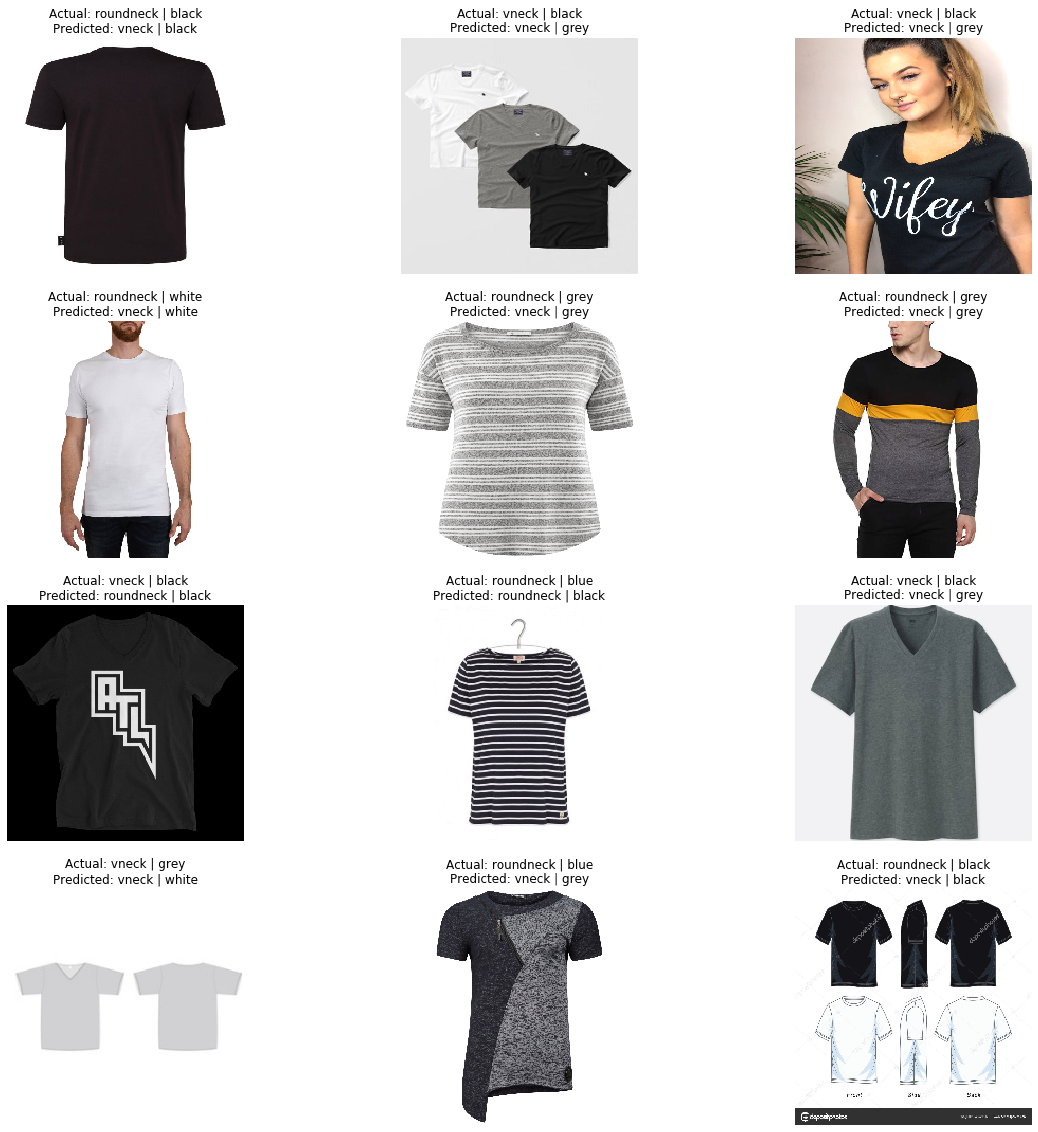

In [46]:
wrong_plot(12, true_wrong, test_images, pred_wrong, target_inv_mappers, inv_normalize)

## plot_confusion_matrix

In [47]:
def plot_confusion_matrix(
    y_true, y_pred, classes, attr_index, normalize=False, title=None, cmap=plt.cm.Blues
):
    """This function prints and plots the confusion matrix.
     
    Args:
        y_true: 2d numpy array of true labels, rows - objects, columns - attributes
        y_pred: 2d numpy array of predicted labels
        classes: list of classes in matrix
        attr_index: int, index of attribute
        normalize:bool, if true - apply normalization 
        title: str
        cmap: plt.cm object, color map

    """
    current_attr = target_attr[attr_index]
    y_true, y_pred = y_true[:, attr_index], y_pred[:, attr_index]
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix, without normalization"
    title += " for {}".format(target_attr[attr_index])
    # Compute confusion matrix
    conf_mx = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        conf_mx = conf_mx.astype("float") / conf_mx.sum(axis=1)[:, np.newaxis]

    # print(conf_mx)

    fig, ax = plt.subplots()
    im = ax.imshow(conf_mx, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(conf_mx.shape[1]),
        yticks=np.arange(conf_mx.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = conf_mx.max() / 2.0
    for i in range(conf_mx.shape[0]):
        for j in range(conf_mx.shape[1]):
            ax.text(
                j,
                i,
                format(conf_mx[i, j], fmt),
                ha="center",
                va="center",
                color="white" if conf_mx[i, j] > thresh else "black",
            )
    fig.tight_layout()
    return ax

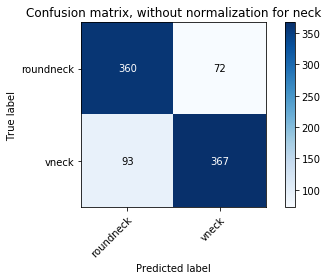

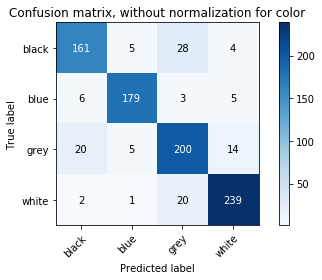

In [48]:
for i, attr in enumerate(target_attr):

    plot_confusion_matrix(
        true,
        pred,
        classes=mapper[attr].keys(),
        attr_index=i,
        title="Confusion matrix, without normalization",
    )

## Prediction bar for single image

In [49]:
def prediction_bar(output, encoder):
    """This function prints and plots the prediction bar.

    Args:
        output: pytorch tensor, with model output
        encoder: dict map int label -> string label

    """
    print("\nprediction_bar:")
    output = output.cpu().detach().numpy()
    a = output.argsort()
    a = a[0]

    size = len(a)
    if size > 5:
        a = np.flip(a[-5:])
    else:
        a = np.flip(a[-1 * size :])
    prediction = list()
    clas = list()
    for i in a:
        prediction.append(float(output[:, i] * 100))
        clas.append(encoder[int(i)])
    for i in a:
        print(
            "Class: {} , confidence: {}".format(
                encoder[int(i)], float(output[:, i] * 100)
            )
        )
    plt.bar(clas, prediction)
    plt.title("Confidence score bar graph")
    plt.xlabel("Confidence score")
    plt.ylabel("Class number")
    plt.show()


def img_tensor_plot(image, inv_normalize=None):
    """This function plot the pytorch tensor(image).

    Args:
        image: pytorch tensor 
        inv_normalize: albumentation transoform

    """
    image = image.cpu().numpy().squeeze()
    image = image.transpose(1, 2, 0)
    if inv_normalize is not None:
        augmented = inv_normalize(image=image)
        image = augmented["image"]
    plt.imshow(image)
    plt.show()

In [65]:
def predict_single_image(
    model,
    image_path,
    transform,
    device="cpu",
    target_inv_mappers=None,
    true_label=None,
    verbose=False,
):
    """This function take image path and predict labels, plot prediction bar.

    Args:
        model: pytorch neural net
        image_path: string, image path
        transform: transformation defined with albumentation library
        device: 'cpu' or 'cuda'
        target_inv_mappers: list of dicts, each dict map int_label -> string label
        true_label: str, true label of image
        verbose: if true - plot prediction bar 
    Return:
        list of predicted attributes
    """
    test_image = cv2.imread(image_path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    # test_image - np.array()
    if verbose:
        plt.imshow(test_image)
        plt.show()
    if transform:
        augmented = transform(image=test_image)
        test_image_tensor = augmented["image"]
    else:
        test_image_tensor = torch.Tensor(test_image)

    test_image_tensor = test_image_tensor.type(torch.FloatTensor)
    test_image_tensor = test_image_tensor.expand(1, -1, -1, -1).to(device)
    model.to(device)

    with torch.no_grad():
        model.eval()
        sm = nn.Softmax(dim=1)
        output = model(test_image_tensor)
        # output_per_class = torch.split(output, num_classes, dim=1)
        output_per_class = output
        i = 0
        predicted_classes = []
        for out, idx_to_class in zip(output_per_class, target_inv_mappers):
            out = sm(out)
            _, preds = torch.max(out, 1)
            predicted_class = idx_to_class[preds.cpu().numpy()[0]]
            predicted_classes.append(predicted_class)
            if verbose:
                print("Output class: ", predicted_class)
                if true_label is not None:
                    print("True class: ", idx_to_class[true_label[i]])
                fig = plt.figure()
                prediction_bar(out, idx_to_class)
            i += 1
    return predicted_classes

path = ../Fashion_datasets/my_dataset/vneck_white\00000299.jpg


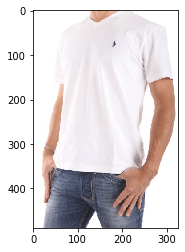

Output class:  vneck
True class:  vneck

prediction_bar:
Class: vneck , confidence: 83.78937530517578
Class: roundneck , confidence: 16.210628509521484


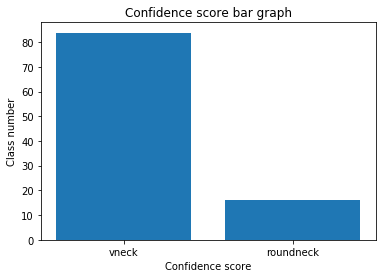

Output class:  white
True class:  white

prediction_bar:
Class: white , confidence: 99.918212890625
Class: grey , confidence: 0.052572764456272125
Class: black , confidence: 0.028489520773291588
Class: blue , confidence: 0.0007175342761911452


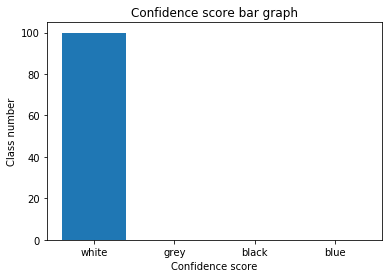

In [66]:
img_path = random_name = np.random.choice(valid_data.dataset.img_paths)
print("path =", random_name)
true_label = labels_df.loc[
    labels_df["path"] == random_name, target_attr
].values.squeeze()
predicted_class = predict_single_image(
    model,
    img_path,
    image_transforms["valid"],
    "cpu",
    target_inv_mappers,
    true_label,
    verbose=True,
)

## Visual Explanations with GradCam

In [52]:
for param in model.parameters():
    param.requires_grad = True

In [67]:
def torch_to_np_image(image):
    # swap color axis because
    # numpy image: H x W x C
    # torch image: C X H X W
    image = image.cpu().numpy().squeeze()
    image = image.transpose(1, 2, 0)
    return image


def visualize_cam(mask, img):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]

    Return:
        np_img (numpy.array): defined image
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    np_img = torch_to_np_image(img)
    mask = mask.cpu().squeeze()  # mask shape = (H,W)
    # grayscale to b, g, r image
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = heatmap / float(255)
    # Heatmap.shape = (H, W, 3)

    # from b, g, r to rgb image
    b, g, r = np.split(heatmap, 3, axis=2)
    heatmap = np.dstack([r, g, b])

    if inv_normalize is not None:
        augmented = inv_normalize(image=np_img)
        np_img = augmented["image"]
    result = heatmap + np_img
    result = result / result.max()

    return np_img, heatmap, result

In [68]:
def gen_vis_gradcam(img_name, class_idx=None):
    """This function takes the path of the file, loads it,
    and produces a visual explanation calculated using gradCam and gradCampp techniques.
    
    Args:
        img_name: str, path to image
        class_idx: int, index of interested class

    Return:
        concat_image: numpy array, the final image consists of 6 parts:
        the original image, the heatmap and their union, for gradcam and gradcampp.
    """
    np_image = cv2.imread(img_name)
    np_image = cv2.cvtColor(np_image, cv2.COLOR_BGR2RGB)
    augmented = image_transforms["valid"](image=np_image)
    torch_img = augmented["image"]
    normed_torch_img = torch_img.unsqueeze(0).to(device)
    resnet_model_dict = dict(
        type="resnet",
        arch=model.backbone,
        layer_name="layer4",
        input_size=(im_crop, im_crop),
    )

    resnet_gradcam = GradCAM(resnet_model_dict, verbose=False)
    resnet_gradcampp = GradCAMpp(resnet_model_dict, verbose=False)

    # cam_dict['resnet'] = [resnet_gradcam, resnet_gradcampp]
    mask1, _ = resnet_gradcam(normed_torch_img, class_idx=class_idx, retain_graph=False)
    mask2, _ = resnet_gradcampp(
        normed_torch_img, class_idx=class_idx, retain_graph=False
    )
    np_img, heatmap, result = visualize_cam(mask1, torch_img)
    np_img2, heatmap2, result2 = visualize_cam(mask2, torch_img)

    concat_image1 = np.concatenate([np_img, heatmap, result], axis=1)
    concat_image2 = np.concatenate([np_img2, heatmap2, result2], axis=1)
    concat_image = np.concatenate([concat_image1, concat_image2], axis=0).clip(0, 1)
    return concat_image

In [69]:
def plot_random_image_with_grad(dataloader, device, pred_class_verbose=False):
    """this function loads a random image from the dataloader,
    calculates the prediction of the model and, if necessary, outputs a prediction bar for each attribute.
    Сall the gen_vis_grandcam() function and plot results.
    
    
    Args:
        dataloader: pytorch dataloader with img_paths attribute
        device: str, cpu or cuda
        class_idx: int, index of interested class

    Return:
        concat_image: numpy array, the final image consists of 6 parts:
        the original image, the heatmap and their union, for gradcam and gradcampp.
    """
    model.to(device)
    idx = np.random.choice(dataloader.dataset.img_paths.index)
    img_name = labels_df.loc[idx, "path"]
    true_label = labels_df.loc[idx, target_attr].values
    predicted_class = predict_single_image(
        model,
        img_name,
        image_transforms["valid"],
        device,
        target_inv_mappers,
        true_label=true_label,
        verbose=pred_class_verbose,
    )

    concat_image = gen_vis_gradcam(img_name)
    fig, ax = plt.subplots(figsize=(10, 10))
    correct_label = decode_label(true_label, target_inv_mappers)
    predicted_label = " |".join(predicted_class)
    title = "Actual:" + correct_label + "\n" + "Predicted:" + predicted_label
    plt.title(title)
    ax.set(ylabel="GradCAMcpp" + " " * 40 + "GradCAM")
    ax.imshow(concat_image)

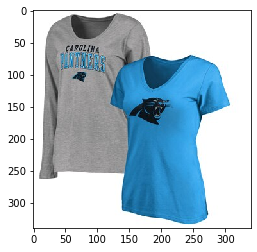

Output class:  vneck
True class:  vneck

prediction_bar:
Class: vneck , confidence: 92.10650634765625
Class: roundneck , confidence: 7.893493175506592


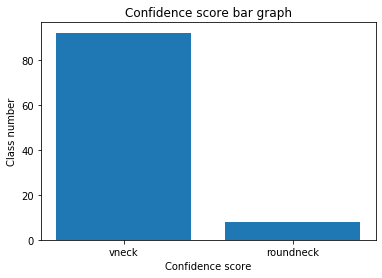

Output class:  grey
True class:  grey

prediction_bar:
Class: grey , confidence: 97.9270248413086
Class: blue , confidence: 1.3326256275177002
Class: black , confidence: 0.41757532954216003
Class: white , confidence: 0.3227749168872833


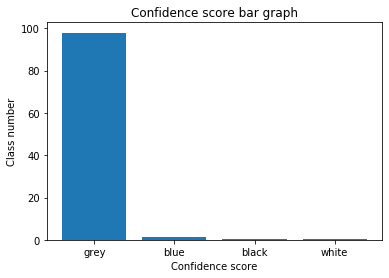

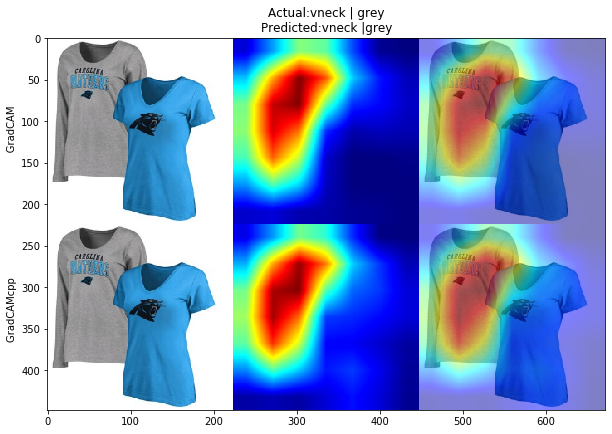

In [72]:
plot_random_image_with_grad(valid_data, device, pred_class_verbose=True)

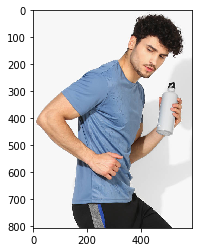

Output class:  roundneck
True class:  roundneck

prediction_bar:
Class: roundneck , confidence: 91.80513763427734
Class: vneck , confidence: 8.194862365722656


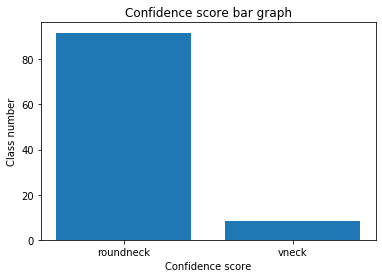

Output class:  blue
True class:  blue

prediction_bar:
Class: blue , confidence: 92.87619018554688
Class: grey , confidence: 4.304845809936523
Class: black , confidence: 2.4625117778778076
Class: white , confidence: 0.35644984245300293


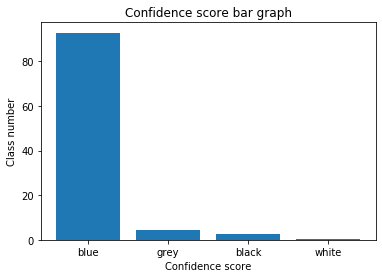

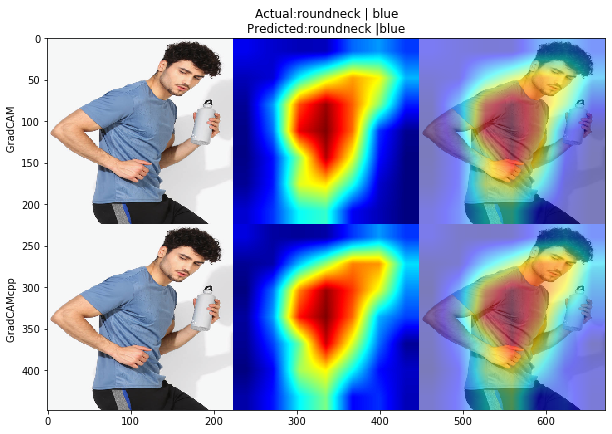

In [75]:
plot_random_image_with_grad(valid_data, device, pred_class_verbose=True)

## Result metrics

In [76]:
for i, attr in enumerate(target_attr):
    print(attr, "performance_metrics:")
    performance_metrics(true[:, i], pred[:, i])
    print()

neck performance_metrics:
Precision: 81.53464375688274 Recall: 81.55797101449276, Accuracy: 81.50224215246637: ,f1_score: 81.50110292038234

color performance_metrics:
Precision: 87.57459011179365 Recall: 87.24065692919274, Accuracy: 87.33183856502242: ,f1_score: 87.38268658258698

